In [ ]:
# Import relevant functionality
from langchain.chat_models import init_chat_model
from langchain_tavily import TavilySearch
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent

# Create the agent
memory = MemorySaver()
model = init_chat_model("anthropic:claude-3-5-sonnet-latest")
# search = TavilySearch(max_results=2)
# tools = [search]
# agent_executor = create_react_agent(model, tools, checkpointer=memory)


{('user', 'chatbot'): Text(0.05942949912067941, 0.3354978354978353, 'ask'),
 ('chatbot',
  'user'): Text(-0.05942949912067952, -0.33549783549783574, 'response')}

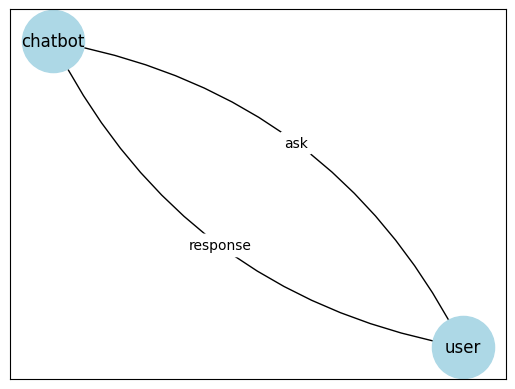

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import my_networkx as mnx

# Chatbot without RAG
G = nx.DiGraph()
edge_list = [('user','chatbot',{'w': 'ask'}),
             ('chatbot','user',{'w': 'response'})]
G.add_edges_from(edge_list)
pos = nx.spring_layout(G, seed=5)
fig, ax = plt.subplots()
nx.draw_networkx_nodes(G, pos, ax=ax, node_color='lightblue',node_size=2000)
nx.draw_networkx_labels(G, pos, ax=ax)
curved_edges = [edge for edge in G.edges() if reversed(edge) in G.edges()]
arc_rad = 0.25
nx.draw_networkx_edges(G, pos, ax=ax, edgelist=curved_edges,
                       connectionstyle=f'arc3, rad = {arc_rad}')

edge_weights = nx.get_edge_attributes(G, 'w')
curved_edge_labels = {edge: edge_weights[edge] for edge in curved_edges}
mnx.my_draw_networkx_edge_labels(G, pos, ax=ax,
                             edge_labels=curved_edge_labels, rotate=False,
                             rad=arc_rad)

# Summary: chatbot can respond to common questions but not with the latest or domain-specific knowledge
# Ex: What's my mother's name?


{('user', 'chatbot'): Text(-0.507736511059772, -0.018309906626825023, 'ask'),
 ('chatbot',
  'user'): Text(-0.4922326252305709, 0.03545867194388441, 'response'),
 ('chatbot',
  'k_base'): Text(0.4889253589369633, -0.03450337614670135, 'query'),
 ('k_base',
  'chatbot'): Text(0.5110746410630367, 0.019260224084264976, 'knowledge')}

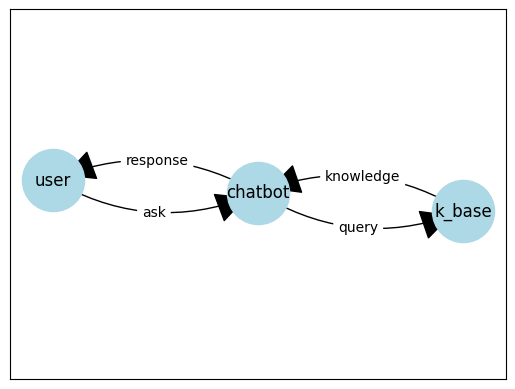

In [14]:
# RAG System
G = nx.DiGraph()
edge_list2 = [('user','chatbot',{'w': 'ask'}),
              ('chatbot','user',{'w': 'response'}),
              ('chatbot','k_base',{'w': 'query'}),
              ('k_base','chatbot',{'w': 'knowledge'})]

G.add_edges_from(edge_list2)
pos = nx.spring_layout(G, seed=5)
fig, ax = plt.subplots()
nx.draw_networkx_nodes(G, pos, ax=ax, node_color='lightblue',node_size=2000)
nx.draw_networkx_labels(G, pos, ax=ax)
curved_edges = [edge for edge in G.edges() if reversed(edge) in G.edges()]
arc_rad = 0.25
nx.draw_networkx_edges(G, pos, ax=ax, edgelist=curved_edges, arrowsize=50,
                       connectionstyle=f'arc3, rad = {arc_rad}')

edge_weights = nx.get_edge_attributes(G, 'w')
curved_edge_labels = {edge: edge_weights[edge] for edge in curved_edges}
mnx.my_draw_networkx_edge_labels(G, pos, ax=ax,
                             edge_labels=curved_edge_labels, rotate=False,
                             rad=arc_rad)

In [1]:
# Simple RAG
# Embedding model: pre-trained model that converts input to vector representations that capture semantics
# Vector db: storage system for knowledge
# Chatbot: language model generating responses
# Indexing: break dataset into small chunks and calculate vector

# bge-base-en-v1.5 for embedding
# Llama-3.2-1B-Instruct for language

import pymupdf4llm

fout = 'output.txt'

# Loading dataset
dataset = []
with open(fout, 'r') as file:
  dataset = file.readlines()
  print(f'Loaded {len(dataset)} entries')

# Vector db
import ollama

EMBEDDING_MODEL = 'hf.co/CompendiumLabs/bge-base-en-v1.5-gguf'
LANGUAGE_MODEL = 'hf.co/bartowski/Llama-3.2-1B-Instruct-GGUF'

# Elements are tuples (chunk, embedding)
# Embeddings are float lists
VECTOR_DB = []
def add_chunk_to_database(chunk):
  embedding = ollama.embed(model=EMBEDDING_MODEL, input=chunk)['embeddings'][0]
  VECTOR_DB.append((chunk, embedding))

# each line is a chunk for simplicity
for i, chunk in enumerate(dataset):
  add_chunk_to_database(chunk)
  print(f'Added chunk {i+1}/{len(dataset)} to the database')

# similarity between vectors
def cosine_similarity(a, b):
  dot_product = sum([x * y for x, y in zip(a, b)])
  norm_a = sum([x ** 2 for x in a]) ** 0.5
  norm_b = sum([x ** 2 for x in b]) ** 0.5
  return dot_product / (norm_a * norm_b)

# retrieval function
def retrieve(query, top_n=3):
  query_embedding = ollama.embed(model=EMBEDDING_MODEL, input=query)['embeddings'][0]
  # temporary list to store (chunk, similarity) pairs
  similarities = []
  for chunk, embedding in VECTOR_DB:
    similarity = cosine_similarity(query_embedding, embedding)
    similarities.append((chunk, similarity))
  # sort by similarity in descending order, because higher similarity means more relevant chunks
  similarities.sort(key=lambda x: x[1], reverse=True)
  # finally, return the top N most relevant chunks
  return similarities[:top_n]

# generation phase
input_query = input('Ask me a question: ')
retrieved_knowledge = retrieve(input_query)

print('Retrieved knowledge:')
for chunk, similarity in retrieved_knowledge:
  print(f' - (similarity: {similarity:.2f}) {chunk}')

instruction_prompt = f'''You are a helpful chatbot.
Use only the following pieces of context to answer the question. Don't make up any new information:
'''
for chunk, similarity in retrieved_knowledge:
    print(f' - {chunk}')


# ollama chatbot
stream = ollama.chat(
  model=LANGUAGE_MODEL,
  messages=[
    {'role': 'system', 'content': instruction_prompt},
    {'role': 'user', 'content': input_query},
  ],
  stream=True,
)

# print the response from the chatbot in real-time
print('Chatbot response:')
for chunk in stream:
  print(chunk['message']['content'], end='', flush=True)

Loaded 13843 entries
Added chunk 1/13843 to the database
Added chunk 2/13843 to the database
Added chunk 3/13843 to the database
Added chunk 4/13843 to the database
Added chunk 5/13843 to the database
Added chunk 6/13843 to the database
Added chunk 7/13843 to the database
Added chunk 8/13843 to the database
Added chunk 9/13843 to the database
Added chunk 10/13843 to the database
Added chunk 11/13843 to the database
Added chunk 12/13843 to the database
Added chunk 13/13843 to the database
Added chunk 14/13843 to the database
Added chunk 15/13843 to the database
Added chunk 16/13843 to the database
Added chunk 17/13843 to the database
Added chunk 18/13843 to the database
Added chunk 19/13843 to the database
Added chunk 20/13843 to the database
Added chunk 21/13843 to the database
Added chunk 22/13843 to the database
Added chunk 23/13843 to the database
Added chunk 24/13843 to the database
Added chunk 25/13843 to the database
Added chunk 26/13843 to the database
Added chunk 27/13843 to th

Ask me a question:  What is kubernetes? Can it be used in robotics?


Retrieved knowledge:
 - (similarity: 0.81) Kubernetes is a platform for creating, deploying, and managing

 - (similarity: 0.80) your use of Kubernetes.

 - (similarity: 0.80) core concepts in Kubernetes and the motivations behind the development

 - Kubernetes is a platform for creating, deploying, and managing

 - your use of Kubernetes.

 - core concepts in Kubernetes and the motivations behind the development

Chatbot response:
Kubernetes is an open-source container orchestration system for automating and managing containerized applications. It was developed by Google and published under the Apache 2.0 license.

Yes, Kubernetes can be used in robotics. In fact, many companies are using it to manage and deploy their robotic systems. The key idea behind Kubernetes is that robots can run on a variety of platforms, including Linux servers or specialized robot-specific operating systems, and they need to be able to communicate with other robots and humans to work effectively.

Kubernete